In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# converting functions for voltage to phase

# --- Parameter ---
N       = 10_000  # 10_000
K       = 1_000   # 1_000

V_T     = 1.0
V_R     = 0.0

nu      = 10*Hz
J_0     = 1.0
tau_m   = 10*ms

I_0 = nu * J_0 * tau_m
Iext_const = np.sqrt(K) * I_0
w_inh = J_0/np.sqrt(K)

def T_free(tau = tau_m, VT=V_T, VR=V_R, I_ext=Iext_const):
    ln = np.log((VT-I_ext)/(VR-Iext_const))
    return -tau * ln

def phi(V):
    Tfree = T_free(tau = tau_m, VT=V_T, VR=V_R, I_ext=Iext_const)
    return - tau_m / Tfree *(np.log((V-Iext_const)/(V_R-Iext_const)))

def phi_inv(phi, C = Iext_const, tau_m = tau_m):
    Tfree = T_free(tau = tau_m, VT=V_T, VR=V_R, I_ext=Iext_const)/ms
    exponent = - phi * Tfree / (tau_m/ms)
    return (V_R - C) * np.exp(exponent) + C

In [ ]:
def run_w_startvector(runtime, startvector):   #enter the runtime in seconds but with the unit
    
    start_scope()
    # Brian Zeitschritt (bei kontinuierlicher Simulation)

    defaultclock.dt = 0.1*ms

    # Simulationsdauer
    


    # --- Parameter ---
    N       = 10_000  # 10_000
    K       = 1_000   # 1_000

    V_T     = 1.0
    V_R     = 0.0

    nu      = 10*Hz
    J_0     = 1.0
    tau_m   = 10*ms




        # balanced-state prediction (eq. (5)): nu ~ nu_bal = I_0/(J_0*tau_m)  -> I_0 ~ nu*J_0*tau_m
    I_0 = nu * J_0 * tau_m

    Iext_const = np.sqrt(K) * I_0  # These inputs counteract the constant excitatory current
    w_inh = J_0/np.sqrt(K)  # neurons receive exclusively inhibitory recurrent inputs
    # NOTE S = Synapses(G, G, on_pre="V -= w_inh")  # inhibitory undelayed pulse 
                


    # --- Neuronmodell (Voltage-LIF) ---
    # Paper: tau_m dV/dt = -V + I(t) (1), mit I(t)=sqrt(K)*I_0 - (J_0/sqrt(K))*sum delta(...)
    # In Brian: wir modellieren I_ext als konstanten Term im ODE und synaptische Pulse als Sprung in V.
    eqs = """
    dV/dt = (-V + I_ext)/tau_m : 1  # NOTE dimensionslos (V normiert und dimensionslos im Paper)
    I_ext : 1                       # NOTE dimensionslos
    """

    G = NeuronGroup(
        N,
        model=eqs,
        threshold="V >= V_T",
        reset="V = V_R",
        method="euler"
    )

    # Initialisierung
    G.V = startvector    # TODO: alternative Initialisierung?
    G.I_ext = Iext_const    # REVIEW: Ich habe aus der Übung nicht verstanden, wie wir die Delta-Funktion hinbekommen..


    # --- Konnektivität: gerichteter Erdős–Rényi mit mittlerem In-degree K ---
    p = K / (N-1)   # p in (0,1)



    seed(0)           # Brian2 seed
    S = Synapses(G, G, on_pre="V -= w_inh")  # inhibitory undelayed pulse 
    S.connect(condition='i!=j', p=p)



    #sp_mon = SpikeMonitor(G)

    mon_all_V = StateMonitor(G, 'V', record=True) #((len(indices), len(t)))


    # --- Run ---
    print(f"\nRunning simulation for T = {runtime}...")

    # Set BOTH seeds right after start_scope()

    run(runtime)
    mon_endvalues = np.array(G.V)
    print("Done!")

    return mon_endvalues, mon_all_V



In [4]:
# create an initial random vector to have a random starting point for the simulation
initial_randvector = np.random.rand(10000)

# run it for 8 seconds and return the resulting voltage
runtime = 8*second
V_0, trajectory_V_0  = run_w_startvector(runtime, initial_randvector)

#run it again but now from the resulting vector of the previous run
runtime = 1*second
V_5, trajectory_V_5  = run_w_startvector(runtime, V_0)


/Users/ulasayyilmaz/Library/Caches/cython/brian_extensions/_cython_magic_21fb162c99135c53270c0c1e881daffc.cpp:1194:14: fatal error: 'cstdlib' file not found
 1194 |     #include <cstdlib>
      |              ^~~~~~~~~
1 error generated.
WARNING    Cannot use Cython, a test compilation failed: command '/usr/bin/clang++' failed with exit code 1 (CompileError)
Certain compiler configurations (e.g. clang in a conda environment on OS X) are known to be problematic. Note that you can switch the compiler by setting the 'CC' and 'CXX' environment variables. For example, you may want to try 'CC=gcc' and 'CXX=g++'. [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]



Running simulation for T = 8. s...
Done!

Running simulation for T = 1. s...
Done!


In [5]:
print(V_0[9999]) # V_0 (10000,)
# print(len(trajectory_V_0)) # len 80000 for 8 seconds of 10000 observations each
print(len(trajectory_V_5)) # 10k for 1 second of 10k observations
print(initial_randvector[9999]) # a vector of length 10k between 0 and 1, initial voltage dist f0r neurons

0.26250140523312276
10000
0.13342010467257315


In [6]:
#convert to phase
phase_V_0 = phi(V_0)

#create and add the random vector (perturb in phase space)
r = np.random.normal(0,1,N)
r /= np.linalg.norm(r)
#print(r)
phase_V_0_shift = phase_V_0 + r
#print(phase_V_0)
#print(phase_V_0_shift)

#convert the phase perturbed V0 back to voltages
V_0e = phi_inv(phase_V_0_shift)
#print(V_0)
#print(V_0e)

In [13]:
print(trajectory_V_5.V.shape)

(10000, 10000)


In [18]:
#Now run as before but from the slighly altered starting point
V_5e, trajectory_V_5e = run_w_startvector(runtime, V_0e)
#print(V_5)
#print(V_5e)


#Calculate the difference of the two trajectories (taking the absolute values)
#  D_phi(t) = |phi(V) - phi_e(V)|
# diff_eps = np.abs(trajectory_V_5.V - trajectory_V_5e.V)
phase_V_5_shift=phi(trajectory_V_5.V)
phase_V_5e_shift=phi(trajectory_V_5e.V)
diff_eps_phase = np.abs(phase_V_5_shift - phase_V_5e_shift)


#convert voltage to phase again
# diff_eps_phase = phi(diff_eps)

# sum this up over the neurons for all the timesteps
# diff_over_neurons = diff_eps_phase.sum(axis=0)
diff_over_neurons_normalized_Ulas = diff_eps_phase.sum(axis=0) / 10000



Running simulation for T = 1. s...
Done!


In [81]:
def plot_time_difference(diff_over_neurons_normalized,runtime):
    # plt.plot(diff_over_neurons)
    plt.plot(diff_over_neurons_normalized)
    plt.xlabel(f'runtime {runtime} ms / timestep (0.1ms)')
    plt.ylabel(f'total difference in phases over {N} Neurons')
    plt.title(r'Time dependent difference $D_{\phi}(t) = \|\phi(V(t)) - \phi(V_{\varepsilon}(t))\|$')
    plt.legend()

WARNING    /var/folders/xx/n40fck0j351db72x3rp26qq00000gn/T/ipykernel_13556/1078236017.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
 [py.warnings]


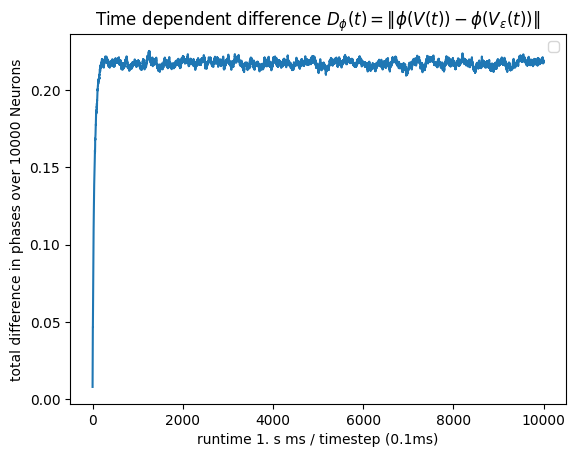

In [36]:
plot_time_difference(diff_over_neurons_normalized_Ulas,1*second) # 1*s

In this particular selection of perturbation constant epsilon, we observe that, after running V5 and V5_e for 1 seconds (10k timesteps), the time dependent difference between two initial voltage values of the neurons increase and stabilize around 0.22 m volts. This indicate the perturbed initial voltage starting point finds stability in a flux tube different than the unperturbed voltage. Average difference between final voltages =  0.22 m volts.

In [82]:
# find an epsilon that decreases (converges in the same flux tube), and an epsilon that increases.
# we already have our normalized random vector r = np.random.normal(0,1,N),  r /= np.linalg.norm(r)
# so we scale it up and down and try to find bifurcation values for epsilon in our system 
# - leading to convergence of the same flux tube vs different flux tube
epsilon_array_high=[-1000,-100,1,100,1000]
epsilon_array_low=[-1,-0.1,0.01,0.1,1]

r = np.random.normal(0,1,N)
r /= np.linalg.norm(r)

In [83]:
def simulate_epsilon_differences(eps_array,r,V0,runtime):
    phase_V0=phi(V0)
    # phase_epsilon_arrays=[]
    # V0e_arrays=[]
    V1e_arrays=[]
    # run unperturbed voltages again
    V1, trajectory_V1 = run_w_startvector(runtime, V0)
    phase_V1_shift=phi(trajectory_V1.V)

    for eps in eps_array:
        print(f'running for epsilon = {eps}')
        phase_V0e_shift = phase_V0 + (eps*r)
        V0e=phi_inv(phase_V0e_shift)

        # phase_epsilon_arrays.append(phase_V0e_shift)
        # V0e_arrays.append(V0e)
        
        V1e, trajectory_V1e = run_w_startvector(runtime, V0e)
        
        phase_V1e_shift=phi(trajectory_V1e.V)
        diff_eps_phase = np.abs(phase_V1_shift - phase_V1e_shift)

        diff_over_neurons_normalized_Ulas = diff_eps_phase.sum(axis=0) / 10000
        V1e_arrays.append(diff_over_neurons_normalized_Ulas)

        plt.figure()
        plot_time_difference(diff_over_neurons_normalized_Ulas, runtime)
        plt.show()
    return V1e_arrays


Running simulation for T = 1. s...
Done!
running for epsilon = -1

Running simulation for T = 1. s...
Done!


WARNING    /var/folders/xx/n40fck0j351db72x3rp26qq00000gn/T/ipykernel_13556/2410960326.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
 [py.warnings]


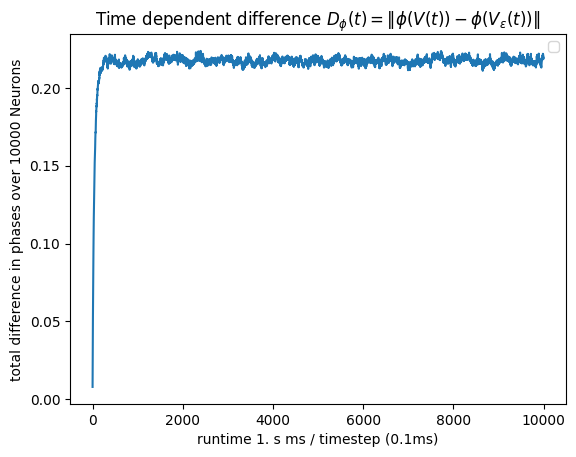

running for epsilon = -0.1

Running simulation for T = 1. s...
Done!


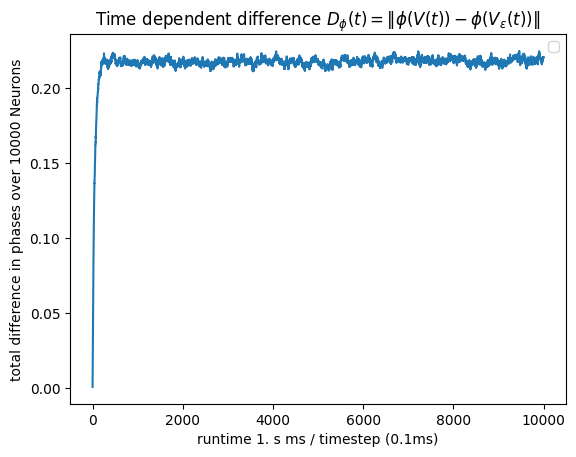

running for epsilon = 0.01

Running simulation for T = 1. s...
Done!


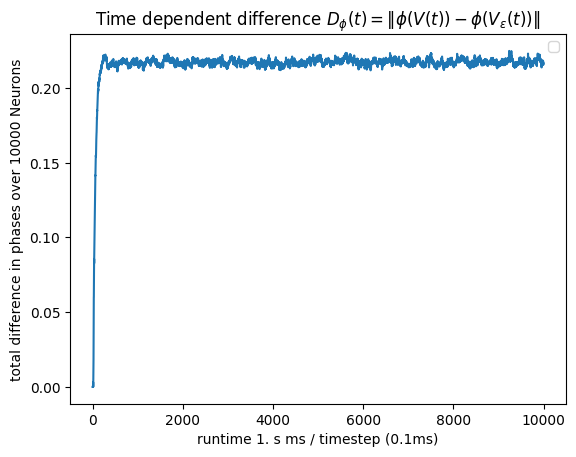

running for epsilon = 0.1

Running simulation for T = 1. s...
Done!


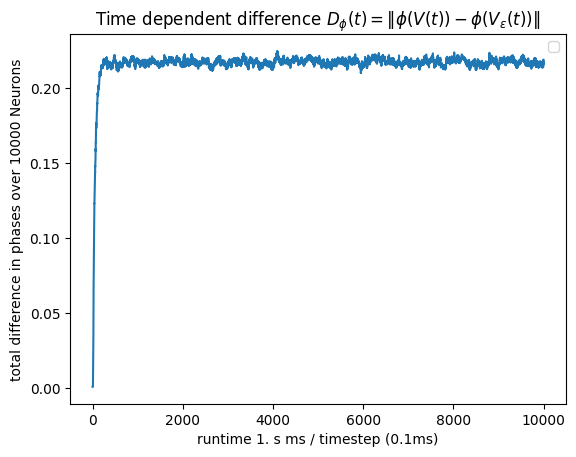

running for epsilon = 1

Running simulation for T = 1. s...
Done!


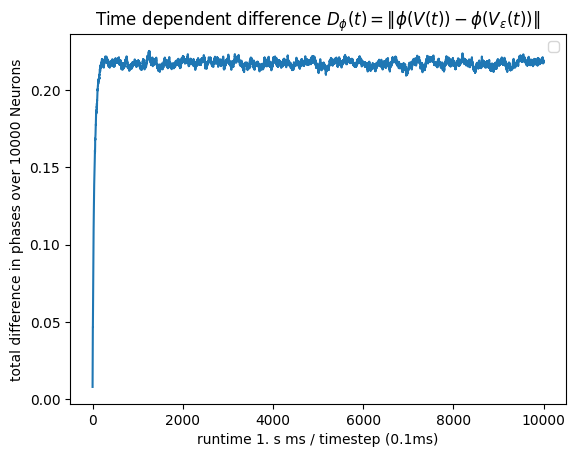

In [84]:
diff_over_neurons_normalized_arr=simulate_epsilon_differences(epsilon_array_low,r,V_0,1*second)



Running simulation for T = 1. s...
Done!
running for epsilon = -1000

Running simulation for T = 1. s...
Done!


WARNING    /var/folders/xx/n40fck0j351db72x3rp26qq00000gn/T/ipykernel_13556/2410960326.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
 [py.warnings]


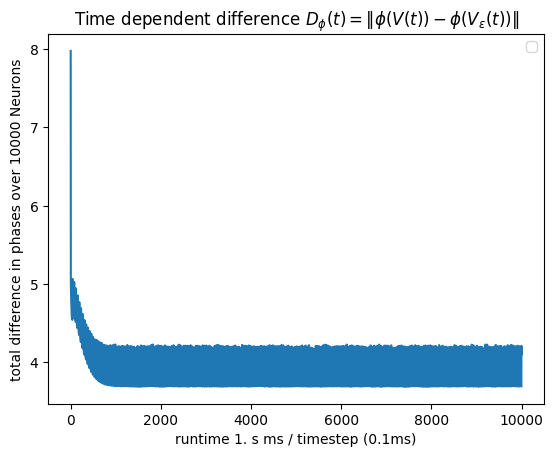

running for epsilon = -100

Running simulation for T = 1. s...
Done!


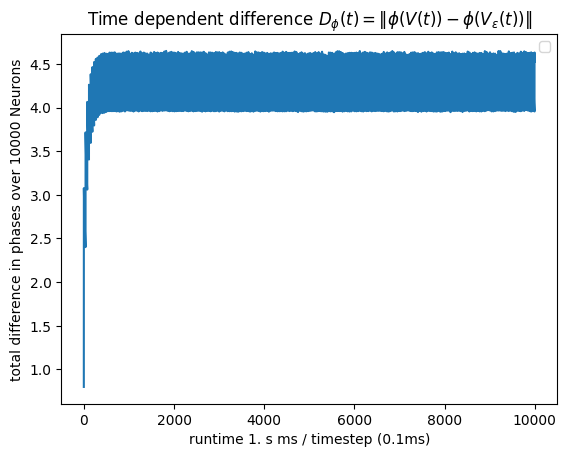

running for epsilon = 1

Running simulation for T = 1. s...
Done!


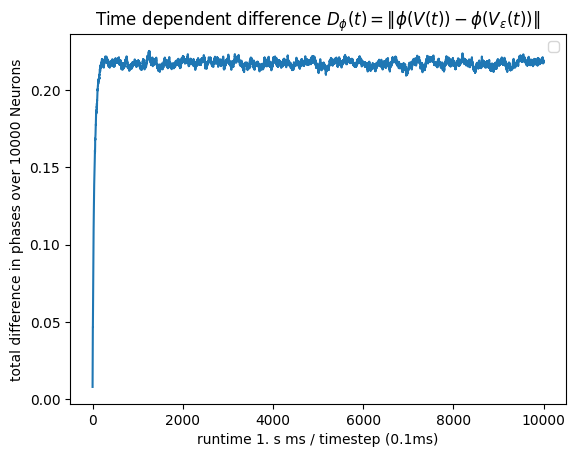

running for epsilon = 100

Running simulation for T = 1. s...
Done!


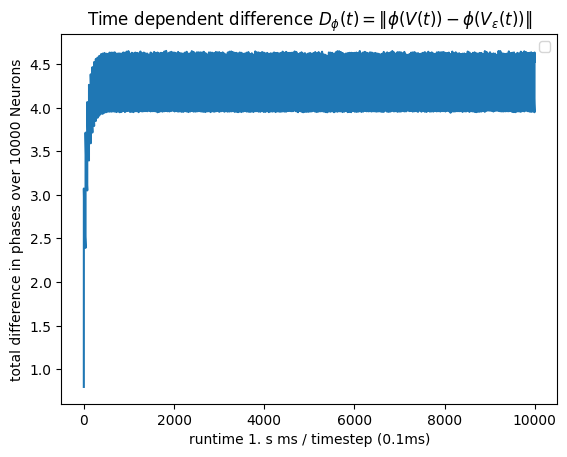

running for epsilon = 1000

Running simulation for T = 1. s...
Done!


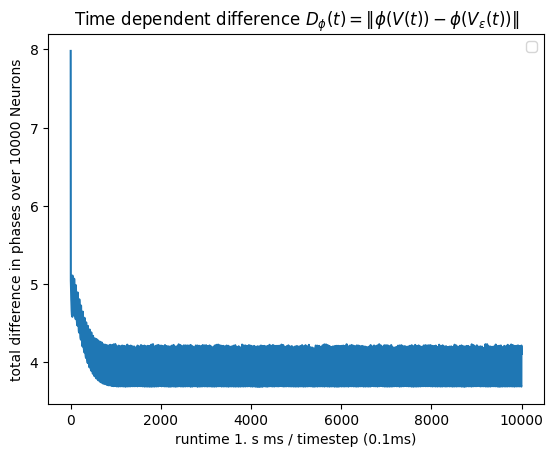

In [85]:
diff_over_neurons_normalized_arr=simulate_epsilon_differences(epsilon_array_high,r,V_0,1*second)

We observe that for epsilon = very high abs values i.e. e=-1000 and e=1000, the difference in phase decreases over time. For all epsilon values between (-100,100), epsilon increases. 

In [ ]:
#check whether phase_eps_arrays and v0e's a bit different from each other
# i checked that both phase_epsilon arrays and v0e_arr's are different from each other.

#now check whether after running all these 5 distinct initialized V0e's for 1 second, 
# if they all converge to the same  v1e
# i checked, all converge to different v1e's.

# now checking for different trajectory_v1e's
#checked all trajectories are diffeerent

#now checking for difference_eps_phase, different (though difference looks small)

# checking for final normalized difference 
# i observe that for 
# neurons' mean voltage values are different initially, as initialized by the epsilon, 
# however, they all converge to the same final value for all epsilons in [0.01,0.1,0.5,2,5]
'''
[7.97997898e-05 7.84657318e-05 7.75393519e-05 ... 2.15529446e-01
 2.15994558e-01 2.16443226e-01]
----------------
[0.000798   0.00078466 0.00077539 ... 0.21896091 0.21717611 0.21613315]
----------------
[0.00398999 0.00972302 0.01271464 ... 0.21631102 0.215698   0.2162542 ]
----------------
[0.01595996 0.03221288 0.0357757  ... 0.21755286 0.21823089 0.21862907]
----------------
[0.03989989 0.09738668 0.07867346 ... 0.21891291 0.21900591 0.21850231]
'''
# with new epsilon array of [-100,-10,-1,1,5,10,100], just observed a different flux tube value for e = -100
# all e=[-10,-1,1,5,10,100] have same flux tube.

# now observed that with e = [-1000,-500,-100,1,100,500,1000], 1 is different than all others, which are the same.
print(diff_over_neurons_normalized_arr[0])
print("----------------")
print(diff_over_neurons_normalized_arr[1])
print("----------------")
print(diff_over_neurons_normalized_arr[2])
print("----------------")
print(diff_over_neurons_normalized_arr[3])
print("----------------")
print(diff_over_neurons_normalized_arr[4])
print("----------------")
print(diff_over_neurons_normalized_arr[5])
print("----------------")


[7.97997898 5.05022311 5.02075916 ... 4.12750086 4.11156296 4.09889233]
----------------
[0.7979979  3.07568976 3.04599681 ... 4.55270747 4.53660715 4.52384193]
----------------
[0.00797998 0.01612596 0.02282226 ... 0.21896656 0.2173291  0.217522  ]
----------------
[0.7979979  3.07271784 3.04310224 ... 4.5545701  4.53829365 4.52551752]
----------------
[7.97997898 5.09788529 5.06850575 ... 4.13792231 4.12178624 4.10917271]
----------------


IndexError: list index out of range